In [1]:
import pandas as pd
import geopandas as gpd
import folium
import numpy as np
import matplotlib as plt
from folium.plugins import HeatMap
import shapely as shp

print("Packages imported.")

Packages imported.


In [2]:
crime = pd.read_csv('CrimeData/all_years_crime_CLEAN.csv', index_col=0)
crime.sample(5)

FID  Record_ID  Offense_Code Offense_Ext Offense_Category  \
25142  25143    1264540          2404           0   STOLEN VEHICLE   
32445  32446    1134929          2999          02        VANDALISM   
34448  34449    1069301          2999          05        VANDALISM   
3461    3462    1224439          5400           1          TRAFFIC   
34207  34208    1068244          2203           0         BURGLARY   

                          Description Police_District Beat  Grid  \
25142   10851(A)VC TAKE VEH W/O OWNER               6   6A  1052   
32445  594(B)(1) VANDL $10000 OR M0RE               4   4B  1302   
34448  594(B)(2)(A) VANDAL UNDER $400               2   2B  0546   
3461      TRAFFIC ACCIDENT-NON-INJURY               6   6D  0844   
34207      459 PC BURG BUSINESS-FORCE               2   2A  0221   

                 Date_Time        Date      Time  Year  Month  Day  Violent  
25142  2017/08/11 23:00:00  2017/08/11  23:00:00  2017      8   11        0  
32445  2015/10/07 18:59:59  2015/10/07  18:59:59  2015     10    7        0  
34448  2014/12/04 07:04:00  2014/12/04  07:04:00  2014     12    4        0  
3461   2017/02/02 03:45:00  2017/02/02  03:45:00  2017      2    2        0  
34207  2014/11/29 15:42:00  2014/11/29  15:42:00  2014     11   29        0

<AxesSubplot:>

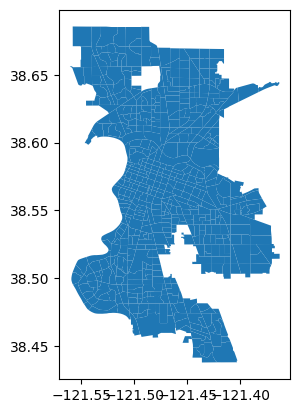

In [3]:
grids = gpd.read_file('GeoData/POLICE_GRIDS-shp/9c1206b0-8fb0-40ef-a00a-ed622069a08f202042-1-714a1w.4dbgd.shp')

%matplotlib inline
grids.plot()

In [4]:
grids.shape

(582, 5)

In [5]:
grids.head()

OBJECTID  GRID    Shape__Are    Shape__Len  \
0         1  0103  2.114470e+07  20060.599963   
1         2  0102  1.375761e+07  19712.913905   
2         3  0106  1.635737e+07  17992.448213   
3         4  0104  1.441308e+07  16029.082122   
4         5  0116  5.199503e+06   9722.395279   

                                            geometry  
0  POLYGON ((-121.51604 38.68520, -121.51604 38.6...  
1  POLYGON ((-121.53605 38.67087, -121.53605 38.6...  
2  POLYGON ((-121.49346 38.67674, -121.49392 38.6...  
3  POLYGON ((-121.50779 38.67082, -121.51073 38.6...  
4  POLYGON ((-121.49346 38.67674, -121.49345 38.6...

'OBJECTID' is unique, 'GRID' is not. We can make the switch later with a mapping, but to ensure all remains unique, I'll use the OBJECTID column to identify the grids uniquely. For convenience, I'd also like to rename the column to 'gid' (for Grid ID).

In [6]:
grids.rename(columns={'OBJECTID':'gid'}, inplace=True)
grids.head()

gid  GRID    Shape__Are    Shape__Len  \
0    1  0103  2.114470e+07  20060.599963   
1    2  0102  1.375761e+07  19712.913905   
2    3  0106  1.635737e+07  17992.448213   
3    4  0104  1.441308e+07  16029.082122   
4    5  0116  5.199503e+06   9722.395279   

                                            geometry  
0  POLYGON ((-121.51604 38.68520, -121.51604 38.6...  
1  POLYGON ((-121.53605 38.67087, -121.53605 38.6...  
2  POLYGON ((-121.49346 38.67674, -121.49392 38.6...  
3  POLYGON ((-121.50779 38.67082, -121.51073 38.6...  
4  POLYGON ((-121.49346 38.67674, -121.49345 38.6...

In [7]:
sacMap = folium.Map(location=[38.57, -121.46],
                    tiles='OpenStreetMap',
                    zoom_start=11)
sacMap

In [8]:
numAllViolentCrimes = crime['Violent'].sum() # this works because 'Violent' is binary: 1 if violent, 0 if not

violentGrids = crime[['Grid', 'Violent']][crime['Violent']==1]
violentGrids = pd.DataFrame(violentGrids.value_counts())

violentGrids.reset_index(inplace=True)
violentGrids.rename(columns={'Violent':'DEL', 0:'Violent'}, inplace=True)
del violentGrids['DEL']
violentGrids.head()

#violentGrids = crime[crime['Violent']==1]['Grid'].value_counts() / crime['Grid'].value_counts()
#violentGrids.fillna(0, inplace=True) # No crime
#violentGrids.head()

Grid  Violent
0  0563      305
1  0746      207
2  0744      198
3  1623      164
4  0564      154

In [9]:
violentGrids['Violent'] = violentGrids['Violent']/violentGrids['Violent'].sum()

In [10]:
violentGrids.head()

Grid   Violent
0  0563  0.023203
1  0746  0.015747
2  0744  0.015063
3  1623  0.012476
4  0564  0.011715

In [11]:
currentGrids = violentGrids['Grid'].to_list()
allGrids = grids['GRID'].to_list()

missingGrids = list(set(allGrids) - set(currentGrids))

len(missingGrids)

26

In [12]:
for mg in missingGrids:
    violentGrids = violentGrids.append({'Grid':mg, 'Violent':0}, ignore_index=True)

violentGrids.tail(17)

Grid  Violent
562  0101      0.0
563  1204      0.0
564  0201      0.0
565  1531      0.0
566  1263      0.0
567  0335      0.0
568  0108      0.0
569  1006      0.0
570  1281      0.0
571  0781      0.0
572  1341      0.0
573  0711      0.0
574  0203      0.0
575  0924      0.0
576  0318      0.0
577  0343      0.0
578  1619      0.0

In [13]:
folium.Choropleth(
    geo_data=grids,
    name='choropleth',
    data=violentGrids,
    columns=['Grid', 'Violent'],
    key_on='feature.properties.GRID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Share of Violent Crime'
).add_to(sacMap)

In [14]:
sacMap

We need to deal with the fact that the original grids DataFrame has duplicates. Let's see what those are:

In [16]:
grids[grids.duplicated(subset='GRID', keep=False)]

gid  GRID    Shape__Are    Shape__Len  \
268  269  0786  3.523999e+05   3442.864576   
269  270  0786  1.192122e+06   4574.838989   
335  336  0721  9.154998e+04   1560.539470   
568  569  0721  4.793899e+06  12605.277905   
569  570  0712  9.839214e+06  14876.527476   
570  571  0712  4.848257e+05   3122.719627   
577  578  0776  2.039542e+05   2155.390121   
578  579  0776  6.763609e+05   3290.275941   

                                              geometry  
268  POLYGON ((-121.48601 38.56604, -121.48625 38.5...  
269  POLYGON ((-121.48334 38.56533, -121.48429 38.5...  
335  POLYGON ((-121.50296 38.58545, -121.50294 38.5...  
568  POLYGON ((-121.50394 38.59699, -121.50401 38.5...  
569  POLYGON ((-121.49269 38.59236, -121.49052 38.5...  
570  POLYGON ((-121.49924 38.58441, -121.49928 38.5...  
577  POLYGON ((-121.48507 38.56822, -121.48530 38.5...  
578  POLYGON ((-121.48240 38.56751, -121.48287 38.5...

Grid numbers: 0786; 0721; 0712; and 0776 have duplicates. I think it would be a good move to see these on a map.

In [17]:
dupeMap = folium.Map(location=[38.57, -121.46],
                    tiles='OpenStreetMap',
                    zoom_start=11)

In [19]:
folium.Choropleth(
    geo_data=grids,
    name='choropleth',
    data=violentGrids,
    columns=['Grid', 'Violent'],
    key_on='feature.properties.GRID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Share of Violent Crime'
).add_to(dupeMap)

In [20]:
dupeMap

<h2>Issue: the duplicates in the GeoJSON file mess up this algorithm because it doesn't know what to do with two polygons at once. Likely solution will have to be to drop the duplicates, but I'd like to look into those more.